<a href="https://colab.research.google.com/github/Batman511/Image_comparison/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BC%D0%B8%D0%BA%D1%80%D0%BE%D1%81%D1%85%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/Проекты_МИФИ/АСЭ анализ микросхем'

In [116]:
folds_path = '/content/drive/My Drive/Colab Notebooks/Проекты_МИФИ/АСЭ анализ микросхем/'
# images_path = [os.path.join(folds_path, image_name) for image_name in os.listdir(folds_path)]
# print(len(images_path))

benchmark_path = folds_path + 'TL16C752BTPTREP/14270175-x1(10).jpg'
check_path = folds_path + 'TL16C752BTPTREP/14270175-x1(12).jpg'


benchmark_path_nice = folds_path + 'CY7C65620-56LTXC/13820005-X1 (2).jpg'
check_path_nice = folds_path + 'CY7C65620-56LTXC/13820005-X2 (1).jpg'

In [167]:
def visualisation_pair(benchmark_path = benchmark_path, check_path = check_path, BIN = False):
    plt.figure(figsize=(8,8))

    if BIN:
        plt.subplot(1, 2, 1)
        plt.title("Benchmark Image")
        img1 = cv2.imread(benchmark_path, cv2.IMREAD_GRAYSCALE)
        _, bin_im = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(bin_im, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Check Image")
        img2 = cv2.imread(check_path, cv2.IMREAD_GRAYSCALE)
        _, bin_im = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(bin_im, cmap='gray')
        plt.axis('off')
    else:
        plt.subplot(1, 2, 1)
        plt.title("Benchmark Image")
        plt.imshow(Image.open(benchmark_path).convert('LA'))
        plt.axis('off')


        plt.subplot(1, 2, 2)
        plt.title("Check Image")
        plt.imshow(Image.open(check_path).convert('LA'))
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

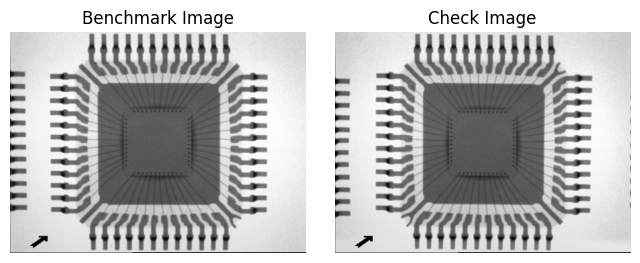

In [168]:
visualisation_pair()

## 1. Алгоритмы хэширования

Чем меньше значение хеширования, тем больше сходство

https://russianblogs.com/article/9659423292/

In [113]:
# Средний хэш-алгоритм
def aHash(img):
    dim1 = dim2 = 50
    img = cv2.resize(img, (dim1, dim2))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # s - пиксель, hash_str - начальное значение хеш-значения
    s = 0
    hash_str = ''

    for i in range(dim1):
        for j in range(dim2):
            s = s+gray[i, j]

    avg = s/(dim1*dim2)

    # Генерация хэша
    # Если уровень серого больше среднего значения, то 1, иначе 0.
    for i in range(dim1):
        for j in range(dim2):
            if gray[i, j] > avg:
                hash_str = hash_str+'1'
            else:
                hash_str = hash_str+'0'
    return hash_str



# Разностный хэш-алгоритм
def dHash(img):
    dim1 = dim2 = 50
    img = cv2.resize(img, (dim1+1, dim2))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''

    # Генерация хэша
    # Если первый пиксель каждой строки больше, чем следующий, то 1, иначе  0
    for i in range(dim1):
        for j in range(dim2):
            if gray[i, j] > gray[i, j+1]:
                hash_str = hash_str+'1'
            else:
                hash_str = hash_str+'0'
    return hash_str



# алгоритм хеширования с косинусоидальным преобразованием
def pHash(img):
    dim1 = dim2 = 50
    img = cv2.resize(img, (dim1, dim2))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Преобразовать изображение в  тип с плавающей точкой, а затем выполнить DCT преобразование
    dct = cv2.dct(np.float32(gray))
    dct_roi = dct[0:16, 0:16]

    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash



# Сравнение хеш-значений
def cmpHash(hash1, hash2):
    n = 0
    # Если длина хеша отличается, возвращается -1, чтобы указать на ошибку
    if len(hash1) != len(hash2):
        return -1

    # Обход изображений
    for i in range(len(hash1)):
        if hash1[i] != hash2[i]:
            n += 1

    return n

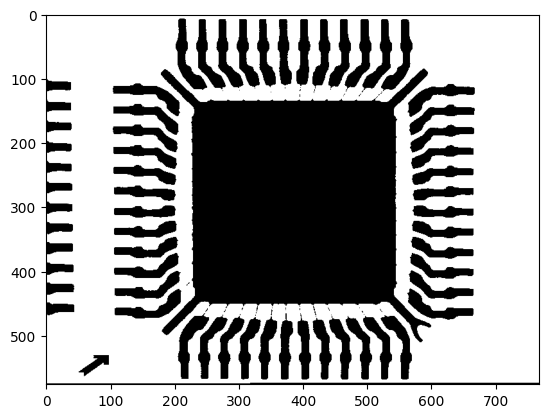

In [161]:
'''
# Бинаризация картинки

img = cv2.imread(benchmark_path, cv2.IMREAD_GRAYSCALE)
_, bin_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(bin_im, cmap='gray')
'''

In [152]:
def convert_to_bin(benchmark_path):
    img = cv2.imread(benchmark_path, cv2.IMREAD_GRAYSCALE)
    _, bin_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bin_img = img2 = np.asarray(Image.fromarray(cv2.cvtColor(bin_im, cv2.COLOR_BGR2RGB)))
    return bin_img


def difference_hash(def_hash, benchmark_path = benchmark_path, check_path = check_path, BIN = False):
    if BIN:
        img1 = convert_to_bin(benchmark_path)
        img2 = convert_to_bin(check_path)
    else:
        img1 = cv2.imread(benchmark_path)
        img2 = cv2.imread(check_path)

    hash1 = def_hash(img1)
    hash2 = def_hash(img2)
    diff = cmpHash(hash1, hash2)
    print (f'Значение сходства алгоритма хеширования {def_hash.__name__}:', diff)


def difference_all_hash(benchmark_path = benchmark_path, check_path = check_path, BIN = False):
    visualisation_pair(benchmark_path, check_path, BIN)
    difference_hash(aHash, benchmark_path, check_path, BIN)
    difference_hash(dHash, benchmark_path, check_path, BIN)
    difference_hash(pHash, benchmark_path, check_path, BIN)

Схемы с дефектами:

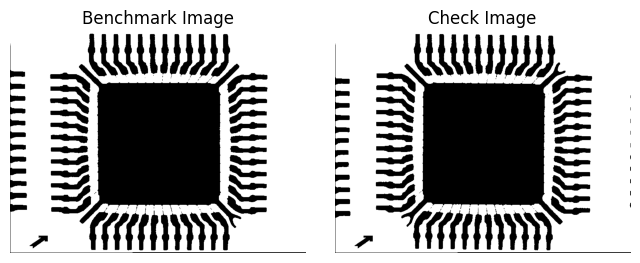

Значение сходства алгоритма хеширования aHash: 237
Значение сходства алгоритма хеширования dHash: 134
Значение сходства алгоритма хеширования pHash: 45


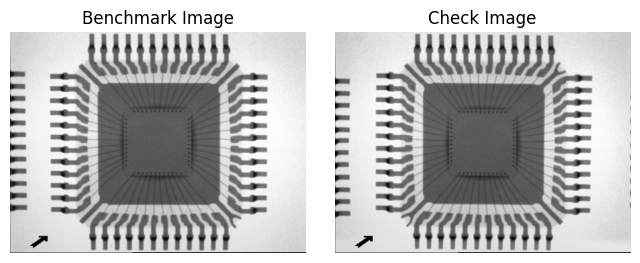

Значение сходства алгоритма хеширования aHash: 275
Значение сходства алгоритма хеширования dHash: 538
Значение сходства алгоритма хеширования pHash: 14


In [169]:
difference_all_hash(BIN = True)
difference_all_hash()

Корректные схемы:

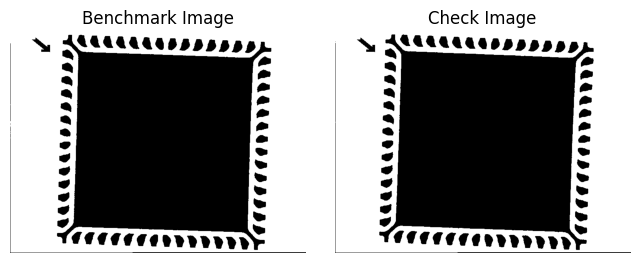

Значение сходства алгоритма хеширования aHash: 165
Значение сходства алгоритма хеширования dHash: 179
Значение сходства алгоритма хеширования pHash: 33


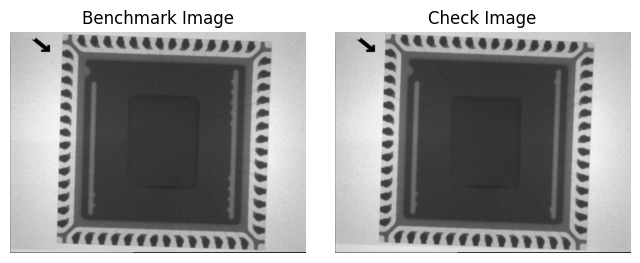

Значение сходства алгоритма хеширования aHash: 160
Значение сходства алгоритма хеширования dHash: 778
Значение сходства алгоритма хеширования pHash: 10


In [170]:
difference_all_hash(benchmark_path_nice, check_path_nice, BIN = True)
difference_all_hash(benchmark_path_nice, check_path_nice)

Вывод: значение хэша зависит от расположения изображения, а также от яркости пикселя. Картинки должны быть одного размера. Не устойчив к сдвигу, повороту и оттенку (освещенности).

Бинаризация может "съесть" важную информацию (прозрачный слой)

## 2. Сравнение гистограмм изображений

Чем больше значение, тем больше сходство

In [203]:
def histogram_similarity_1(image1, image2, method: int):
    #  построение гистограмм
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])

    # нормализация
    cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # подсчет схожести
    comparing = cv2.compareHist(hist1, hist2, method)   # 0 метод - Correlation
    return comparing


def histogram_similarity_2(image1, image2):
    #  построение гистограмм
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])

    # нормализация
    cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # подсчет схожести
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree


def histogram_method_2(benchmark_path = benchmark_path, check_path = check_path):
    img1 = cv2.imread(benchmark_path)
    img2 = cv2.imread(check_path)
    n_def = histogram_similarity_2(img1, img2)[0]
    print('Похожесть одноканальных гистограмм: ', n_def)


def histogram_method_1(benchmark_path = benchmark_path, check_path = check_path, method = 0):
    img1 = cv2.imread(benchmark_path)
    img2 = cv2.imread(check_path)
    n_def = histogram_similarity_1(img1, img2, method)
    print('Похожесть одноканальных гистограмм: ', n_def)

In [204]:
histogram_method_1()   # Для схем с деффектами
histogram_method_1(benchmark_path_nice, check_path_nice)  # Для качественных схем

Похожесть одноканальных гистограмм:  0.9836965010552932
Похожесть одноканальных гистограмм:  0.9934457447388423


In [201]:
histogram_method_2()   # Для схем с деффектами
histogram_method_2(benchmark_path_nice, check_path_nice)  # Для качественных схем

Похожесть одноканальных гистограмм:  0.8375683
Похожесть одноканальных гистограмм:  0.8819086


ВЫВОД:

Метод сильно зависит от яркости изображения
Распознать границу не представляется возможным -> не используе

## 3. Structural Similarity Index

https://pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/

## 4. MatchTemplate

https://russianblogs.com/article/60992835390/

0.8852786421775818
0.8852786421775818


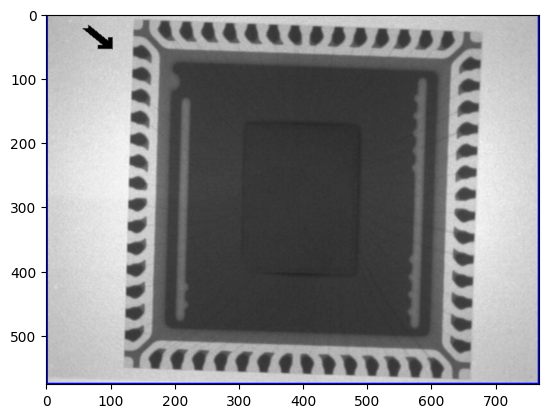

In [ ]:
import cv2 as cv

a=1
if a==1:
    img = cv.imread(images_path[0])
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    template = cv.imread(images_path[3])
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    h, w = template.shape[:2]

    result = cv.matchTemplate(img_gray, template_gray, cv.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    print(max_val)
    print(min_val)

    # max_loc - верхний левый угол
    # Нижний правый угол
    right_bottom = (max_loc[0] + w, max_loc[1] + h)

    # Нарисует прямоугольную рамку вокруг одинаоквой части.
    cv.rectangle(img=img, pt1=max_loc, pt2=right_bottom, color=(0, 0, 255), thickness=3)


    plt.imshow(img)

Вывод: Выделяет похожие части. Может найти картинку в картинке, но мб не сможет обнаружить мелкие детали